In [7]:
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [8]:
data = pd.read_csv("clean.csv")
data

period  duration         depth  planet_radius  stellar_temperature  \
0       9.488036  2.957500    615.800000       2.260000               5455.0   
1      54.418383  4.507000    874.800000       2.830000               5455.0   
2      19.899140  1.782200  10829.000000      14.600000               5853.0   
3       1.736952  2.406410   8079.200000      33.460000               5805.0   
4       2.525592  1.654500    603.300000       2.750000               6031.0   
...          ...       ...           ...            ...                  ...   
17258   3.443800  2.572000   7260.750000            NaN               4805.2   
17259  14.537800  6.826000   4040.000000      16.052300               8007.0   
17260   8.413486  3.556833  17479.605330      20.510696               5786.0   
17261   0.941436  1.360700    339.912662       4.529209               8322.0   
17262   1.507896  2.759000   1839.000000       5.530910               6635.0   

       stellar_gravity  stellar_radius  magnitude          snr  \
0                4.467        0.927000    15.3470    35.800000   
1                4.467        0.927000    15.3470    25.800000   
2                4.544        0.868000    15.4360    76.300000   
3                4.564        0.791000    15.5970   505.600000   
4                4.438        1.046000    15.5090    40.900000   
...                ...             ...        ...          ...   
17258              NaN             NaN    10.0781   700.502570   
17259              NaN        2.050000     9.7925   248.787327   
17260            4.520        0.926261     9.7727  1345.822421   
17261            4.010        2.349860     9.6952    50.328179   
17262            4.350        1.300000     9.6171   305.462273   

       equilibrium_temp  disposition  
0            793.000000            1  
1            443.000000            1  
2            638.000000            2  
3           1395.000000            0  
4           1406.000000            1  
...                 ...          ...  
17258       1708.000000            0  
17259               NaN            0  
17260        857.731431            0  
17261       3641.626449            0  
17262       2762.000000            0  

[17263 rows x 11 columns]

In [9]:
X = data.drop("disposition", axis=1)
Y = data["disposition"]

X = X.fillna(0)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((13810, 10), (3453, 10), (13810,), (3453,))

In [10]:
model = XGBClassifier(
    n_estimators=1050, 
    learning_rate=0.01,
    max_depth=10,
    subsample=0.5,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    random_state=42,
    tree_method="hist",
    eval_metric="mlogloss"
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1050, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
import pickle

# save
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

Accuracy: 0.7688966116420504
              precision    recall  f1-score   support

  Not planet       0.80      0.74      0.77      1225
      Planet       0.78      0.77      0.78       808
   Candidate       0.74      0.79      0.76      1420

    accuracy                           0.77      3453
   macro avg       0.77      0.77      0.77      3453
weighted avg       0.77      0.77      0.77      3453



Matplotlib is building the font cache; this may take a moment.


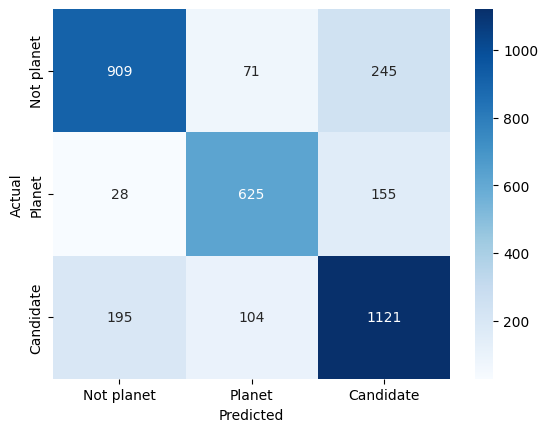

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

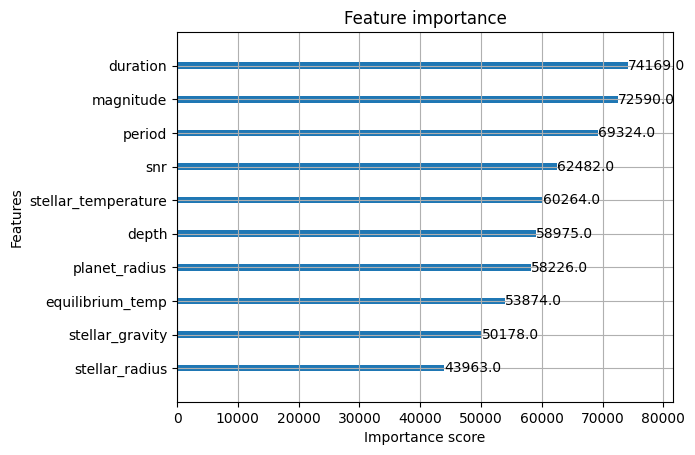

In [12]:
# Predictions
y_pred = model.predict(X_valid)
y_proba = model.predict_proba(X_valid)

# Metrics
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred, target_names=["Not planet", "Planet", "Candidate"]))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not planet","Planet","Candidate"],
            yticklabels=["Not planet","Planet","Candidate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Feature Importance
from xgboost import plot_importance
plot_importance(model)

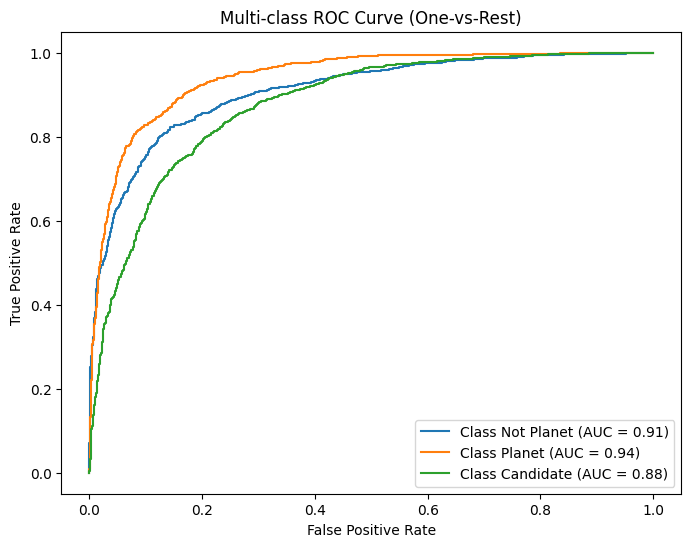

Micro-averaged AUC: 0.9125885908734803


In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

classes = [0, 1, 2]
labels = ["Not Planet", "Planet", "Candidate"]


# Binarize labels for One-vs-Rest
y_test_bin = label_binarize(y_valid, classes=classes)

# Predict probabilities 
y_score = model.predict_proba(X_valid)

# Plot ROC curve for each class
plt.figure(figsize=(8,6))
for i, class_label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()


micro_roc_auc = roc_auc_score(y_test_bin, y_score, average="micro")
print("Micro-averaged AUC:", micro_roc_auc)